# Detector de dígitos (0 a 9) em linguagem de sinais

Este projeto utiliza Redes Neuras Convolutivas para detectar gestos que representam os números de 0 a 9 na linguagem de sinais norte americana (*ASL - American Sign Language*).
Neste projeto utilizei a base de dados disponível em: https://www.kaggle.com/datasets/rayeed045/american-sign-language-digit-dataset

In [8]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
import keras
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping

import carrega_imagens

## 1. Carregando as entradas (X) e saídas (y)

Criamos um script específico (*carrega_imagens.py*) para carregar e transformar as imagens em tensores, e que já faz a separação das entradas e saídas em treino (80%) e teste (20%):

In [6]:
X_train, X_test, y_train, y_test = carrega_imagens.load()

Aplicando *One Hot Encoding* na saída, para conseguirmos realizar a classificação:

In [7]:
y_train_OH = to_categorical(y_train)
y_test_OH = to_categorical(y_test)

## 2. Construção do modelo de Deep Learning (CNNs)

Abaixo definimos uma rede neural de cinco camadas convolutivas, seguidas de duas camadas densas. Alguma experimentação foi feita na definição das quantidades de filtros, tamanho dos kernels e dos pools, para que tivessemos uma rede com uma quantidade razoável de parâmetros treináveis (abaixo de 60k, para o treinamento não ser muito custoso) ao mesmo tempo que a acurácia do set de teste ficasse acima de 98%.

In [14]:
model = Sequential()
model.add(Conv2D(10, kernel_size=5, activation='relu', input_shape=(400,400,1)))
model.add(MaxPool2D(2))

model.add(Conv2D(20, kernel_size=3, activation='relu'))
model.add(MaxPool2D(2))
model.add(Dropout(0.2))

model.add(Conv2D(20, kernel_size=3, activation='relu'))
model.add(MaxPool2D(2))

model.add(Conv2D(10, kernel_size=3, activation='relu'))
model.add(MaxPool2D(2))

model.add(Flatten())
model.add(Dense(10, activation='softmax'))  # 10 dígitos de saída
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 396, 396, 10)      260       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 198, 198, 10)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 196, 196, 20)      1820      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 98, 98, 20)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 98, 98, 20)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 96, 96, 20)       

## 3. Treinamento do modelo

Abaixo realizamos o treinamento do modelo definido, utilizando 20% do set de treino para validação. Também definimos um EarlyStopping para evitar overfitting.

In [16]:
early_stop_monitor = EarlyStopping(patience=2, restore_best_weights=True) 
training = model.fit(X_train, y_train_OH, validation_split=0.2, epochs=30, batch_size=32, callbacks = [early_stop_monitor])

Epoch 1/30
100/100 [==============================] - 263s 3s/step - loss: 1.0133 - accuracy: 0.6450 - val_loss: 0.3918 - val_accuracy: 0.8763
Epoch 2/30
100/100 [==============================] - 270s 3s/step - loss: 0.1889 - accuracy: 0.9422 - val_loss: 0.1740 - val_accuracy: 0.9375
Epoch 3/30
100/100 [==============================] - 266s 3s/step - loss: 0.0660 - accuracy: 0.9803 - val_loss: 0.1677 - val_accuracy: 0.9463
Epoch 4/30
100/100 [==============================] - 262s 3s/step - loss: 0.0354 - accuracy: 0.9894 - val_loss: 0.0745 - val_accuracy: 0.9837
Epoch 5/30
100/100 [==============================] - 275s 3s/step - loss: 0.0273 - accuracy: 0.9937 - val_loss: 0.1232 - val_accuracy: 0.9688
Epoch 6/30
100/100 [==============================] - 278s 3s/step - loss: 0.0139 - accuracy: 0.9959 - val_loss: 0.1311 - val_accuracy: 0.9700


Abaixo podemos visualizar a evolução do processo de treinamento do modelo, comparando o valor do *loss* do set de treino com o *loss* do set de validação. Esta é uma boa maneira de verificar se houve *overfitting*, pois nesse caso veríamos (a partir de em um certo ponto) o valor de *loss* reduzindo mesmo com o *val_loss* aumentando.

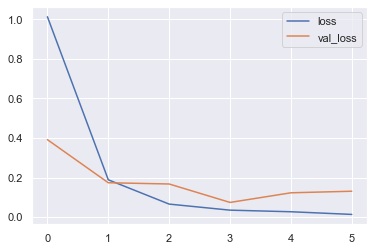

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

A real acurácia do modelo treinado é testada abaixo, na parte dos dados que foi separada para teste:

In [18]:
model.evaluate(X_test, y_test_OH, batch_size=32)

32/32 [==============================] - 24s 761ms/step - loss: 0.0903 - accuracy: 0.9830


[0.09034763276576996, 0.9829999804496765]

Conseguimos uma boa acurácia, acima de 98%, o que mostra que o modelo definido e treinado é bastante satisfatório.

## 4. Salvando o modelo treinado em disco, para futura utilização

Cada vez que este notebook for executado por completo, um novo modelo será criado em salvo em disco, sendo a respectiva data e hora da execução parte integrante do nome dos arquivos:

In [19]:
from datetime import datetime

now = datetime.now()
dt_string = now.strftime("%d-%m-%Y-%H-%M-%S")
model.save('modelo-' + dt_string)
model.save_weights('modelo-' + dt_string + '.h5')

INFO:tensorflow:Assets written to: modelo-21-10-2022-15-17-18\assets


## 5. Quais imagens foram classificadas erroneamente?

Com o intúito de entender melhor os problemas da nossa base de dados, ou até mesmo do nosso modelo, vamos verificar abaixo quais foram as imagens que nosso modelo classificou erroneamente. Assim podemos ter *insights* para futuras melhorias.

In [ ]:
# Get predicted probabilities for test dataset
#y_probs = model.predict(x_test)

# Get predicted labels for test dataset
#y_preds = np.argmax(y_probs, axis=1)

# Indices corresponding to test images which were mislabeled
#bad_test_idxs = np.where(y_preds != y_test)[0]

# Print mislabeled examples
#fig = plt.figure(figsize=(25,4))
#for i, idx in enumerate(bad_test_idxs):
#    ax = fig.add_subplot(2, np.ceil(len(bad_test_idxs)/2), i + 1, xticks=[], yticks=[])
#    ax.imshow(np.squeeze(x_test[idx]))
#    ax.set_title("{} (pred: {})".format(labels[y_test[idx]], labels[y_preds[idx]]))